# Classiq Coding Competition Spring 2022
### Fourth Place MCX Submission by Alexander Gramolin

# Decomposing a multi-controlled Toffoli gate

By [**Alexander Gramolin**](https://www.linkedin.com/in/gramolin)

This is my submission to the [second problem](https://www.classiq.io/competition/toffoli) of the [Classiq Coding Competition](https://www.classiq.io/competition). The problem is to decompose a multi-controlled Toffoli (MCX) gate with 14 control qubits into single-qubit and controlled-NOT (CX) gates. It is allowed to use up to five clean auxiliary qubits, which are initialized in the $|0\rangle$ state and should be returned to $|0\rangle$ at the end. The goal is to minimize the circuit depth. In this notebook, I show how to achieve the circuit depth of 90.

In [1]:
import numpy as np
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import array_to_latex

Let me start with inspecting the Qiskit implementation of the regular Toffoli gate. I show below the circuit diagram and the corresponding matrix representation. Note that I follow the [big-endian convention](https://en.wikipedia.org/wiki/Endianness) for consistency with [Nielsen & Chuang](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf).

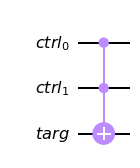

Matrix representation:


<IPython.core.display.Latex object>

In [2]:
def make_circuit(num_ctrl, num_aux=0):
    """Make a circuit with given numbers of control and auxiliary qubits and a single target qubit."""
    c = QuantumRegister(num_ctrl, name="ctrl")
    t = QuantumRegister(1, name="targ")
    a = QuantumRegister(num_aux, name="aux")
    return QuantumCircuit(c, t, a)

def display_matrix(circuit):
    """Display the matrix representation of the circuit."""
    print("Matrix representation:")
    display(array_to_latex(Operator(circuit.reverse_bits()).data, max_size=16))

qc1 = make_circuit(num_ctrl=2)
qc1.ccx(0, 1, 2)
display(qc1.draw(output="mpl"))
display_matrix(qc1)

Recall that each column of this unitary matrix corresponds to the states $|000\rangle$, $|001\rangle$, $|010\rangle$, $|011\rangle$, $|100\rangle$, $|101\rangle$, $|110\rangle$, and $|111\rangle$, respectively. One can immediately see that the Toffoli gate swaps the states $|110\rangle$ and $|111\rangle$ (i.e., the last two columns), without affecting the other states. Note that in the big-endian notation the rightmost qubit corresponds to the bottom wire of the circuit (in our case, to the target qubit). Let me now use Qiskit to transpile the Toffoli gate into single-qubit gates and controlled-NOT (CX) gates.

Circuit depth: 11


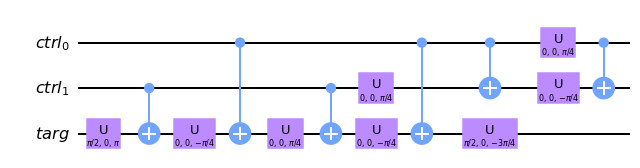

In [3]:
def display_circuit(circuit):
    """Display the circuit diagram and print out its depth."""
    print("Circuit depth: {}".format(circuit.depth()))
    display(circuit.draw(output="mpl", fold=-1))

tqc1 = transpile(qc1, basis_gates=["u", "cx"])
display_circuit(tqc1)

Turns out that the Toffoli gate is implemented in Qiskit with the circuit depth of 11. There is an implementation with the depth of 8, which is reported in Figure 7(a) of [this paper](https://arxiv.org/abs/1206.0758). The more efficient circuit is shown below, along with its matrix (which matches the one above). For future convenience, I created the corresponding custom gate called `toffoli`.

Circuit depth: 8


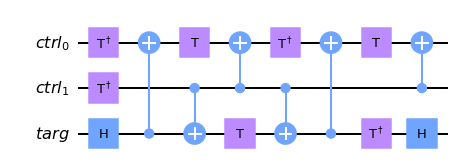

Matrix representation:


<IPython.core.display.Latex object>

In [4]:
qc2 = make_circuit(num_ctrl=2)

qc2.tdg(0)
qc2.tdg(1)
qc2.h(2)
qc2.cx(2, 0)
qc2.t(0)
qc2.cx(1, 2)
qc2.cx(1, 0)
qc2.t(2)
qc2.tdg(0)
qc2.cx(1, 2)
qc2.cx(2, 0)
qc2.t(0)
qc2.tdg(2)
qc2.cx(1, 0)
qc2.h(2)

# My custom Toffoli gate with the depth of 8:
toffoli = qc2.to_gate(label="Tof")

display_circuit(qc2)
display_matrix(qc2)

Let me now consider another circuit, which is very similar to the Toffoli gate.

Circuit depth: 8


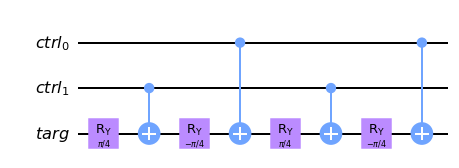

Matrix representation:


<IPython.core.display.Latex object>

In [5]:
qc3 = make_circuit(num_ctrl=2)

qc3.ry(np.pi/4, 2)
qc3.cx(1, 2)
qc3.ry(-np.pi/4, 2)
qc3.cx(0, 2)
qc3.ry(np.pi/4, 2)
qc3.cx(1, 2)
qc3.ry(-np.pi/4, 2)
qc3.cx(0, 2)

# My custom relative-phase Toffoli gate with 2 control qubits and its inverse:
mcx2 = qc3.to_gate(label="mcx$_2$")
mcx2dg = qc3.inverse().to_gate(label="mcx$_2^{\dagger}$")

display_circuit(qc3)
display_matrix(qc3)

One can see from the matrix representation that the only difference with the Toffoli gate is that the state $|111\rangle$ now becomes $-|110\rangle$ instead of $+|110\rangle$. In other words, there is a relative phase of $e^{i\pi} = -1$ for one of the output states. Therefore, this circuit represents one of the [relative-phase Toffoli gates](https://arxiv.org/abs/1508.03273). Importantly, if we use one of the "clean" (i.e., initialized in the state $|0\rangle$) auxiliary qubits as the target qubit for the above circuit, then the input state $|111\rangle$ does not occur at all. Therefore, we can use this circuit instead of the Toffoli gate as long as we ensure that it acts on a "clean" target qubit. For future convenience, I implemented this circuit as a custom gate called `mcx2`. There is also an inverse gate, called `mcx2dg`, which I will use below to uncompute the gate `mcx2`.

But what is the advantage of using this gate if it has the same circuit depth of 8? Well, there is no gain in depth for the 2-controlled gate, but there is some for the case of three control qubits. Consider the following [generalization of the relative-phase Toffoli gate](https://quantumcomputing.stackexchange.com/questions/9842/simpler-implementation-of-the-toffoli-gate-on-ibm-q-for-special-circumstances).

Circuit depth: 16


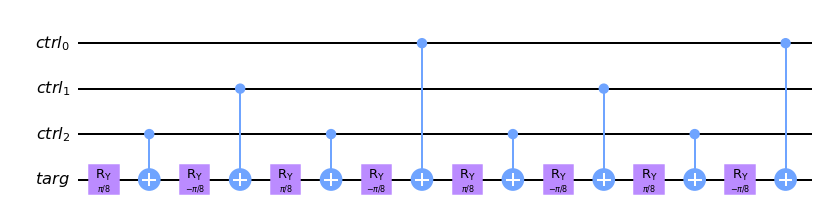

Matrix representation:


<IPython.core.display.Latex object>

In [6]:
qc4 = make_circuit(num_ctrl=3)

qc4.ry(np.pi/8, 3)
qc4.cx(2, 3)
qc4.ry(-np.pi/8, 3)
qc4.cx(1, 3)
qc4.ry(np.pi/8, 3)
qc4.cx(2, 3)
qc4.ry(-np.pi/8, 3)
qc4.cx(0, 3)
half = qc4.copy()
qc4 = qc4.compose(half)

# My custom relative-phase Toffoli gate with 3 control qubits and its inverse:
mcx3 = qc4.to_gate(label="mcx$_3$")
mcx3dg = qc4.inverse().to_gate(label="mcx$_3^{\dagger}$")

display_circuit(qc4)
display_matrix(qc4)

As can be seen from the matrix representation, this circuit maps the state $|1111\rangle$ to $-|1110\rangle$ instead of $+|1110\rangle$, but otherwise is equivalent to the Toffoli gate with three control qubits. I saved this circuit as a custom gate `mcx3`, along with its inverse, `mcx3dg`. The circuit depth is now 16, which is better than $3 \times 8 = 24$ that would be achieved by combining three 2-controlled Toffoli gates (and utilizing an auxiliary gate), as shown below.

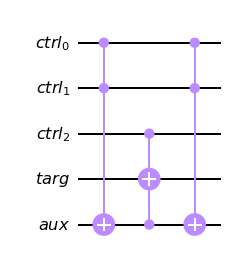

In [7]:
qc5 = make_circuit(num_ctrl=3, num_aux=1)
qc5.ccx(0, 1, 4)
qc5.ccx(2, 4, 3)
qc5.ccx(0, 1, 4)
qc5.draw(output="mpl")

Finally, below is the relative-phase Toffoli gate with four control qubits and the depth of 32. I saved this gate and its inverse as `mcx4` and `mcx4dg`, respectively. Clearly, the circuit depth scales as $2^n$, where $n$ is the total number of qubits. Because of this exponential scaling, it is not benefitial to go too much further. For the desired Toffoli gate with 14 control qubits, the depth would be $2^{15} = 32768$. Instead, I can do much better by exploiting the five auxiliary qubits.

Circuit depth: 32


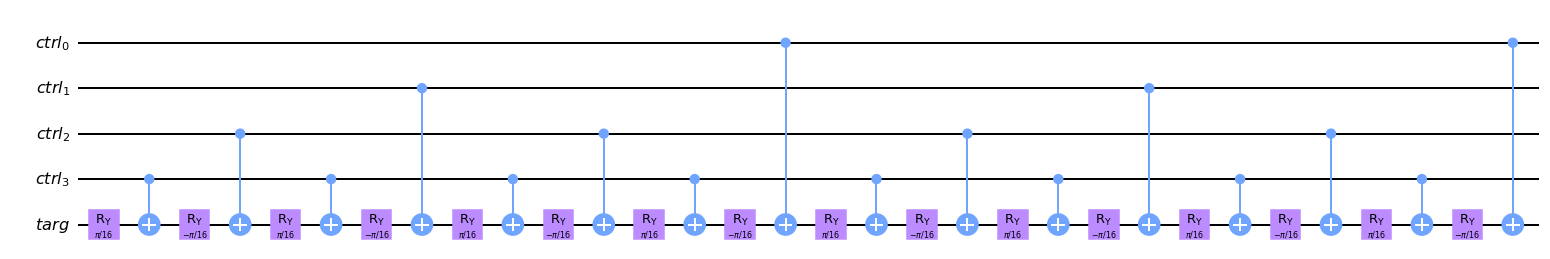

In [8]:
qc6 = make_circuit(num_ctrl=4)

qc6.ry(np.pi/16, 4)
qc6.cx(3, 4)
qc6.ry(-np.pi/16, 4)
qc6.cx(2, 4)
qc6.ry(np.pi/16, 4)
qc6.cx(3, 4)
qc6.ry(-np.pi/16, 4)
qc6.cx(1, 4)
qc6.ry(np.pi/16, 4)
qc6.cx(3, 4)
qc6.ry(-np.pi/16, 4)
qc6.cx(2, 4)
qc6.ry(np.pi/16, 4)
qc6.cx(3, 4)
qc6.ry(-np.pi/16, 4)
qc6.cx(0, 4)
half = qc6.copy()
qc6 = qc6.compose(half)

# My custom relative-phase Toffoli gate with 4 control qubits and its inverse:
mcx4 = qc6.to_gate(label="mcx$_4$")
mcx4dg = qc6.inverse().to_gate(label="mcx$_4^{\dagger}$")

display_circuit(qc6)

Below I show how to combine the custom relative-phase Toffoli gates `mcx2`, `mcx3`, and `mcx4` (along with their inverses) to implement the desired MCX gate with 14 control qubits. I first use the `mcx4` to combine the controls 0, 1, 2, and 3 into the auxiliary qubit 0. Similarly, I combine ctrl$_4$, ctrl$_5$, ctrl$_6$, and ctrl$_7$ to aux$_1$ and also ctrl$_8$, ctrl$_9$, ctrl$_{10}$, and ctrl$_{11}$ to aux$_2$. Note that all three `mcx4` gates operate on different qubits and can therefore be executed simultaneously. This step combines 12 control qubits into 4 ancilla qubits and has the total depth of 32. Next, I use the `mcx3` gate to combine the two remaining control qubits, ctrl$_{12}$ and ctrl$_{13}$, along with the auxiliary qubit aux$_0$, into aux$_3$. Note that this step contributes only 9 qubits to the total depth, since it partially overlaps with the previous step. The total count is now $32 + 9 = 41$. Then, I use the `mcx2` gate to combine aux$_1$ and aux$_2$ into aux$_4$. Remarkably, this gate fully overlaps with the `mcx3` gate and does not increase the circuit depth. Next, I use the `Toffoli` gate of depth 8 to combine aux$_3$ and aux$_4$ into the target gate. Finally I use the `mcx2dg`, `mcx3dg`, and `mcx4dg` gates to uncompute their counterparts and thus release all the auxiliary qubits. The total circuit depth is $(32 + 9) \times 2 + 8 = 90$.

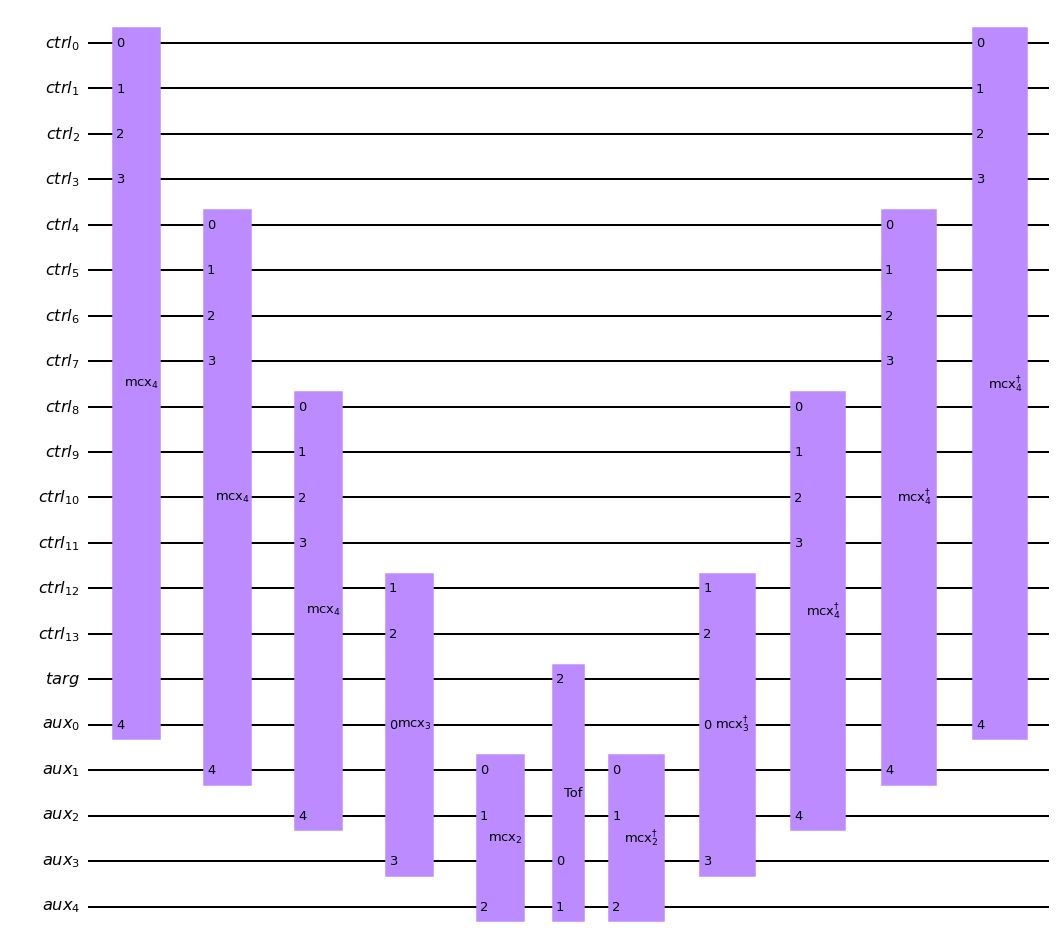

In [9]:
qc7 = make_circuit(num_ctrl=14, num_aux=5)

qc7.append(mcx4, [0, 1, 2, 3, 15])
qc7.append(mcx4, [4, 5, 6, 7, 16])
qc7.append(mcx4, [8, 9, 10, 11, 17])
qc7.append(mcx3, [15, 12, 13, 18])
qc7.append(mcx2, [16, 17, 19])

qc7.append(toffoli, [18, 19, 14]) # Target

# Uncompute:
qc7.append(mcx2dg, [16, 17, 19])
qc7.append(mcx3dg, [15, 12, 13, 18])
qc7.append(mcx4dg, [8, 9, 10, 11, 17])
qc7.append(mcx4dg, [4, 5, 6, 7, 16])
qc7.append(mcx4dg, [0, 1, 2, 3, 15])

qc7.draw(output="mpl", fold=-1)

Below I transpile the full circuit into single-qubit and CX gates and output its depth and the gate counts.

In [10]:
tqc2 = transpile(qc7, basis_gates=["u", "cx"])
print("Circuit depth: {}".format(tqc2.depth()))
print("Number of gates: {} single-qubit gates, {} CX gates".format(tqc2.count_ops()['u'], tqc2.count_ops()['cx']))

Circuit depth: 90
Number of gates: 128 single-qubit gates, 126 CX gates


Finally, I save the transpiled circuit to an OpenQASM file.

In [11]:
tqc2.qasm(formatted=True, filename="Toffoli.qasm")

OPENQASM 2.0;
include "qelib1.inc";
qreg ctrl[14];
qreg targ[1];
qreg aux[5];
u(pi/2,0,pi) targ[0];
u(pi/16,0.0,0.0) aux[0];
cx ctrl[3],aux[0];
u(-pi/16,0.0,0.0) aux[0];
cx ctrl[2],aux[0];
u(pi/16,0.0,0.0) aux[0];
cx ctrl[3],aux[0];
u(-pi/16,0.0,0.0) aux[0];
cx ctrl[1],aux[0];
u(pi/16,0.0,0.0) aux[0];
cx ctrl[3],aux[0];
u(-pi/16,0.0,0.0) aux[0];
cx ctrl[2],aux[0];
u(pi/16,0.0,0.0) aux[0];
cx ctrl[3],aux[0];
u(-pi/16,0.0,0.0) aux[0];
cx ctrl[0],aux[0];
u(pi/16,0.0,0.0) aux[0];
cx ctrl[3],aux[0];
u(-pi/16,0.0,0.0) aux[0];
cx ctrl[2],aux[0];
u(pi/16,0.0,0.0) aux[0];
cx ctrl[3],aux[0];
u(-pi/16,0.0,0.0) aux[0];
cx ctrl[1],aux[0];
u(pi/16,0.0,0.0) aux[0];
cx ctrl[3],aux[0];
u(-pi/16,0.0,0.0) aux[0];
cx ctrl[2],aux[0];
u(pi/16,0.0,0.0) aux[0];
cx ctrl[3],aux[0];
u(-pi/16,0.0,0.0) aux[0];
cx ctrl[0],aux[0];
u(pi/16,0.0,0.0) aux[1];
cx ctrl[7],aux[1];
u(-pi/16,0.0,0.0) aux[1];
cx ctrl[6],aux[1];
u(pi/16,0.0,0.0) aux[1];
cx ctrl[7],aux[1];
u(-pi/16,0.0,0.0) aux[1];
cx ctrl[5],aux[1];
u(pi/16,0.